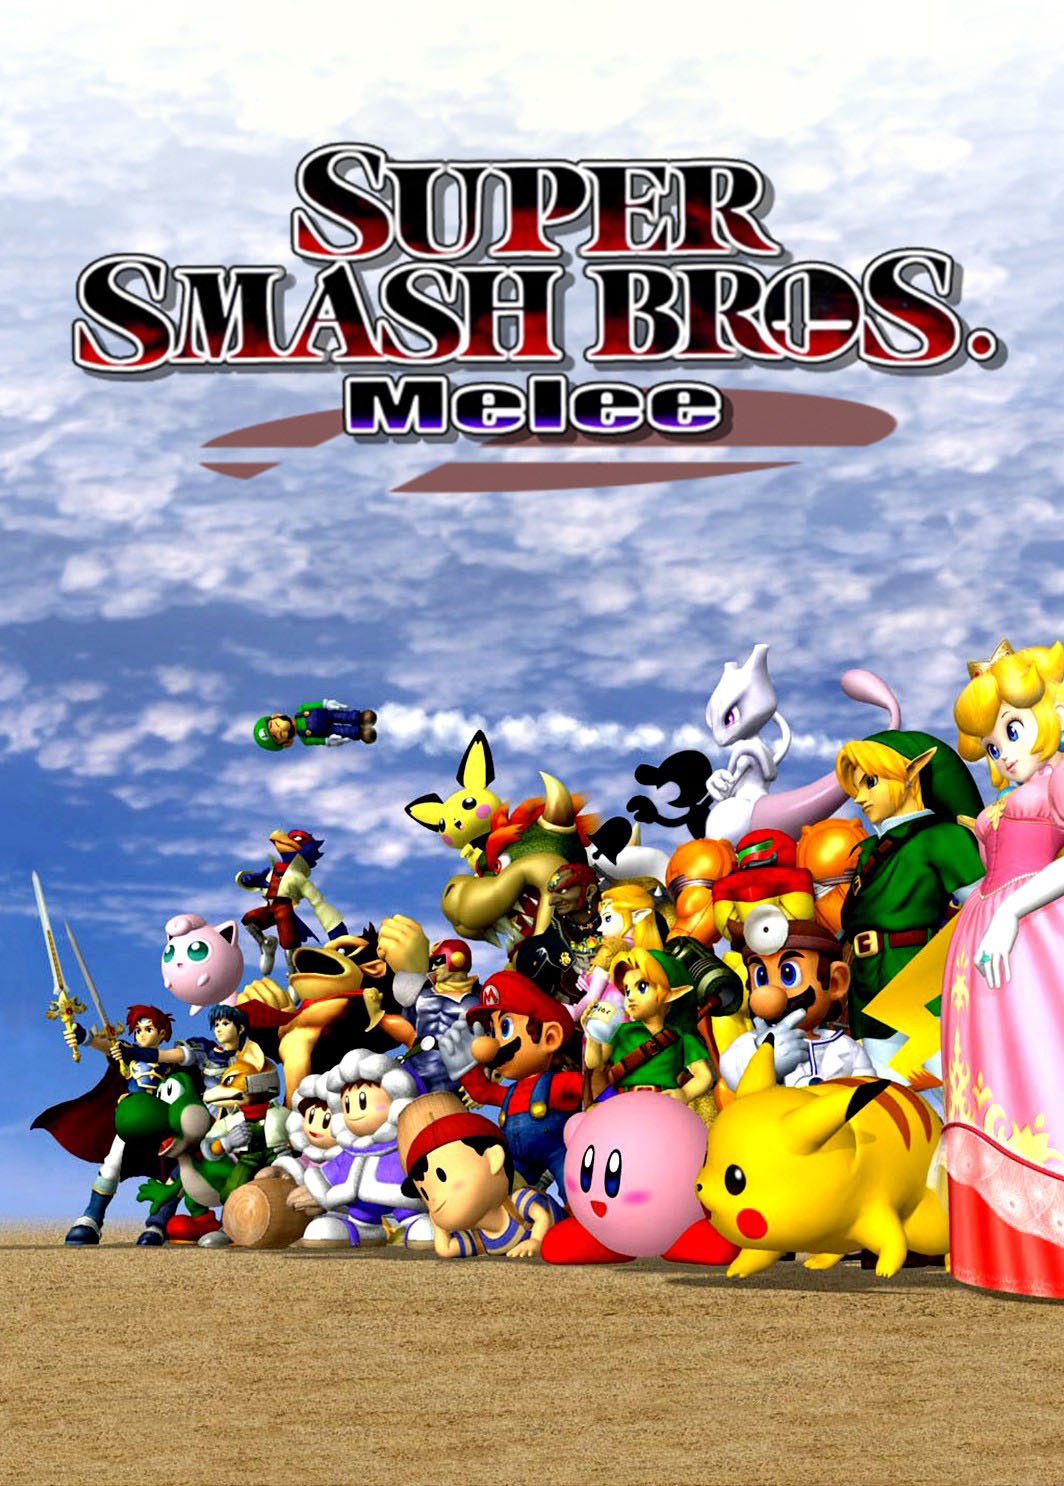
<h1><center>Analyzing Ledge Grabs in Super Smash Bros. Melee</center></h1>
<h2><center>-- Clark Farley and William Fisher --</center></h2>

<h1><center>Introduction</center></h1>
Super Smash Bros. Melee (henceforth “Melee” or “SSBM”) is a platform fighting game developed by Nintendo for the Nintendo GameCube and released in 2001. Since the game’s release, it has been a household favorite and a cult classic, having a strong following to date. Melee has also stayed around for so long because of a large competitive community surrounding the game. Tens of thousands of players still play the game competitively, <a href="https://twitchtracker.com/games/16282">hundreds of thousands watch it</a>, and it <a href="https://www.ssbwiki.com/List_of_largest_Smash_tournaments#Super_Smash_Bros._Melee">regularly has very high attendance at major fighting game tournaments</a>. Why? Melee has a lot of technical depth and potential for “mind games” (tricking your opponent into playing poorly in one way or another), so even today people can find new ways to win a match.

In competitive Melee, there are two main formats. One format is singles, in which two players face off one-on-one. The other format is doubles, in which there are two 2-person teams of players that face off in-game, but we won’t be analysing doubles. In singles, each player picks one character from the roster of 26 characters, and they play on one of 6 legal stages (can vary based on the competition ruleset). Their characters load into the match, both starting at 0%, 4 lives (or “stocks”) and having 8 minutes on the clock. The idea of the match is to raise your opponents percent by hitting them with a variety of damaging moves your character possesses, then knocking them off the stage. As a character's percent builds, they take more knockback when they get hit by a move, making it easier to knock them off the stage. All competitive stages are like large platforms floating in mid air, surrounded by something called a “blast zone”. This blast zone is on the edges of the screen, and if a character touches it, they lose a stock. A game is won by making your opponent lose all their stocks, or running the timer out while having a stock or percent lead (having more stocks or the same amount of stocks and less percent). This second win condition is known as a “time out.” A set is won by winning 2⁄3 games in a best of 3 set, or ⅗ games in a best of 5 set. You can read more about the Melee ruleset <a href=https://www.ssbwiki.com/Tournament_rulesets_(SSBM)>here</a>.

Naturally, one of the best ways to take stocks is to knock a character offstage and make sure they can’t make it back to stage, such that they fall to the bottom blast zone and lose a stock. Melee alleviates this a little bit by providing players with grabbable ledges on the stage. A character may reach the edge of the stage’s main platform and hang off of it, having a little bit of invincibility every time they grab the ledge. From the ledge they can pick one of many options to get off of it and secure a more safe position on the stage.

Now, we’re delving a lot into nuances of the game’s function, but that’s because in this project, we are setting out to analyze a nuanced issue. In Melee, some players have abused this ledge grab system (mainly the invincibility gained from it) to “camp” their opponent out. Specifically, players will grab ledge, granting invincibility then drop from ledge only to grab it again, repeating this process until they decide to go back onto the stage. This strategy is known as “planking” (see https://www.ssbwiki.com/planking). Most players agree that watching someone continuously regrab ledge to abuse the invincibility and run the timer down isn’t very fun to watch or play against, and is an abuse of the game’s mechanics. Recently, there has been discussion about imposing a ledge grab limit on competitive matches, such that if a player grabs the ledge too many times in a single game and that game ends with a time out, they forfeit that game. 

As described in the above article, planking was a serious issue in Melee’s successor, Super Smash Bros. Brawl (henceforth “Brawl”). The Brawl community decided to impose rules that would prevent stalling via planking. At that time, this was not seen as a serious concern for Melee. However, some players have utilized planking to great success recently which has caused increased attention on this topic. For example, Juan “Hungrybox” DeBiedma was playing against Justin "Wizzrobe" Hallett in a best of 5 set at the tournament CEO 2019. In game 3 of this set, Hungrybox grabbed the ledge once every 3.5 seconds on average. His next lowest rate in that same set was 13.2 seconds, a significantly lower amount.

Now, how will we analyze data for an 18 year old game played on a now-archaic console? Well, recently a project has gone through development which allows recording of controller inputs and pulling of game data from Melee matches, such that those matches can be simulated and analyzed at a later date. It is called <a href=https://slippi.gg/faq>Project Slippi</a>, tastefully named after a Nintendo character. We can get the replay files for a Melee tournament and use a Python library to interpret it, organize it, tidy it, and analyze it. The tournament of choice will be <a href=https://www.ssbwiki.com/Tournament:Pound_2019>Pound 2019</a>, one of the largest Melee tournaments of the past year, boasting 451 players and a considerable number of top 100 worldwide Melee players.

In this tutorial, we will examine the game data provided by Pound 2019 to provide insight on the ledge grab mechanic in Super Smash Bros. Melee. We will examine ledge grabs in a given game and how they relate to character, winrate, game length, and more. We will use these relationships, calculated from a sample of games, to extrapolate other games based on independent variables. Finally, we will conclude with suggestions regarding a ledge grab limit rule for competitive Super Smash Bros. Melee.


# Data Collection
## Installations
For this tutorial, we will need the following installs:
* `py-slippi` - Used for processing the .slp game files (some documentation here: https://py-slippi.readthedocs.io/en/latest/source/slippi.html#module-slippi)
* `pandas` - Used for creating data frames to store and manipulate data into an easily-readable format
* `numpy` - Used for more base operations such as array manipulation
* `os` - Used to read files from the computer
* `math` - Used for basic mathematical operations such as finding the floor of a decimal value
* `seaborn` - Used for data visualization and regression

In [1]:
pip install py-slippi

Note: you may need to restart the kernel to use updated packages.


In [35]:
from slippi import Game, id
import slippi
import pandas as pd
import numpy as np
import os
import math
import seaborn as sns
sns.set()
from matplotlib import pyplot as plt

## Reading Files
Reading Files
Before we read the files, we need to make sure we only read the correct files. We’re looking for legitimate tournament singles matches, so we have some criteria to set up.
1. The game contains only two players, playing 1 on 1
2. Both players are human players instead of computer players
3. The game takes place on a tournament legal stage
4. The game ends in either a time out or a normal victory, instead of ending with someone quitting out.

Here, we define a function to count the number of players in a match, and make sure they are human. The list of players (game.start.players) contains information for all of the four controller ports on the GameCube console. If a port says None, there is no player for that port, and if it says the port has player.type = 0, then that player is a human. Then, we have a stage dictionary, which contains all of the six the legal stages and converts a stage’s numerical value into a readable string. We use this dictionary to check that each game is on an allowed stage. This will allow us to find all the game files for 1v1 tournament matches.


In [2]:
# Finds the number of human players in a given game. A player is human if the port is active and the player.type is 0,
# which signifies a human player
def num_players(game):
    num = 0
    for player in game.start.players:
        # Look for valid Player object and make sure it is type Human not CPU
        if player != None and player.type == 0:
            num += 1
    return num

In [3]:
# Maps numerical stage constants to easily interpretable strings.
stage_map = {
    slippi.id.Stage.FOUNTAIN_OF_DREAMS: 'FoD',
    slippi.id.Stage.POKEMON_STADIUM: 'PS',
    slippi.id.Stage.YOSHIS_STORY: 'Yoshi\'s',
    slippi.id.Stage.DREAM_LAND_N64: 'DL',
    slippi.id.Stage.BATTLEFIELD: 'BF',
    slippi.id.Stage.FINAL_DESTINATION: 'FD'
}

Now, we actually begin reading the files. We create a list of files from all streamed matches at Pound 2019 by accessing directories on our machine. Streamed matches were chosen because almost all of them will be competitive, bracket matches instead of casual matches played for fun. We only want to consider tournament matches because we care about the creation of a tournament rule. We select a random sample of 100 tournament matches to analyze.

Next, we define a method to parse these selected files. First and foremost, for a given game, we catch exceptions from erroneous files and delete them, since their data won’t be readable anyways. We also delete games that are not one human player vs another human player, because the proposed rule would only apply in singles. On top of that, we also ignore and delete games that ends with someone pausing and quitting out of the game (“No contest”) because most of the time these games are “hand-warmers”, i.e. just going into a game to warm up movement and other techniques. However, occasionally tournament games end with a player “rage quitting” by using this method, so this may introduce some bias. Finally, we also delete files describing games that take place on an illegal stage, since those are obviously not tournament matches. Nevertheless, we parse all the files into game objects and put these objects into an array.

In [19]:
# We downloaded all the game files for Pound 2019 that were featured on stream, and here we parse them.
files = [entry for entry in os.scandir('./pound-2019-replays/Pound-2019/vgbootcamp')]
files += [entry for entry in os.scandir('./pound-2019-replays/Pound-2019/vgbootcamp2')]
files += [entry for entry in os.scandir('./pound-2019-replays/Pound-2019/vgbootcamp3')]
files = np.array(files)
file_sample = np.random.choice(files, 200)

legal_stages = stage_map.keys()

def create_game(entry):
    try:
        game = Game(entry)
        if num_players(game) != 2 or game.start.is_teams == True:
            print(f"wrong player amount {entry}")
            
        # remove no contest games
        elif (game.end.method == 7):
            print(f"ended with no contest {entry}")
            
        # make sure game is played on a tournament legal stage, if not it should not be included in our data
        elif (game.start.stage not in legal_stages):
            print(f"illegal stage {entry}")

        else:
            return game
    except:
        print(f"{entry} caused an exception")
        
np_game = np.array([create_game(entry) for entry in file_sample])

# Drop Nones from files that had the wrong number of players or caused exceptions
np_game = np_game[np_game != np.array(None)]

<DirEntry 'Game_20190420T171553.slp'> caused an exception
<DirEntry 'Game_20190420T171553.slp'> caused an exception
<DirEntry 'Game_20190420T171553.slp'> caused an exception
<DirEntry 'Game_20190421T003209.slp'> caused an exception


# DATA PROCESSING
## Definitions
We have all the games in an array, but we want to translate them into a manipulable and readable dataframe. So, we define a few more functions and another dictionary. First, we define a character dictionary, which converts a character’s numerical value into a readable string.

In [5]:
# Maps numerical character constants to easily interpretable strings. Note there are 27 entries, but that is because
# the character Ice Climbers consists of two characters controlled at once, Popo and Nana.
character_map = {
    slippi.id.InGameCharacter.MARIO: 'Mario',
    slippi.id.InGameCharacter.FOX: 'Fox',
    slippi.id.InGameCharacter.CAPTAIN_FALCON: 'C-falcon',
    slippi.id.InGameCharacter.DONKEY_KONG: 'DK',
    slippi.id.InGameCharacter.KIRBY: 'Kirby',
    slippi.id.InGameCharacter.BOWSER: 'Bowser',
    slippi.id.InGameCharacter.LINK: 'Link',
    slippi.id.InGameCharacter.SHEIK: 'Sheik',
    slippi.id.InGameCharacter.NESS: 'Ness',
    slippi.id.InGameCharacter.PEACH: 'Peach',
    slippi.id.InGameCharacter.POPO: 'ICs',
    slippi.id.InGameCharacter.NANA: 'ICs',
    slippi.id.InGameCharacter.PIKACHU: 'Pikachu',
    slippi.id.InGameCharacter.SAMUS: 'Samus',
    slippi.id.InGameCharacter.YOSHI: 'Yoshi',
    slippi.id.InGameCharacter.JIGGLYPUFF: 'Jiggs',
    slippi.id.InGameCharacter.MEWTWO: 'Mewtwo',
    slippi.id.InGameCharacter.LUIGI: 'Luigi',
    slippi.id.InGameCharacter.MARTH: 'Marth',
    slippi.id.InGameCharacter.ZELDA: 'Zelda',
    slippi.id.InGameCharacter.YOUNG_LINK: 'Y Link',
    slippi.id.InGameCharacter.DR_MARIO: 'Doc',
    slippi.id.InGameCharacter.FALCO: 'Falco',
    slippi.id.InGameCharacter.PICHU: 'Pichu',
    slippi.id.InGameCharacter.GAME_AND_WATCH: 'Mr GaW',
    slippi.id.InGameCharacter.GANONDORF: 'Ganon',
    slippi.id.InGameCharacter.ROY: 'Roy'
}

Now we define a couple more functions to tell us a bit more information about the game. The first function, find_players(game), takes a game and puts the two players into a 1x2 array. The second one, find_winner(game), determines the winner based on the game data. Remember that a win is decided when one player loses all of their stocks, or when the match goes to time and either one player has more stocks than the other player, or they have even stocks and one player has less percent damage than the other player. We use the last frame of the game to determine the winner because it’s the end of the game, one way or another.

In [22]:
# Puts all the players from the active ports into a list
def find_players(game):
    return [x for x, y in enumerate(game.start.players) if y != None]

# Returns the winner of a given game as a Player object.
# It takes the last frame of the game and analyzes the game state to determine the winner.
def find_winner(game):
    players = find_players(game)
    last = game.frames[-1]
    # pn_stock stores the number of stocks left for player number n
    p1_stock = last.ports[players[0]].leader.post.stocks
    p2_stock = last.ports[players[1]].leader.post.stocks
    # If one player has more stocks at the end of the game, they are the winner
    if p1_stock > p2_stock:
        return players[0]
    elif p2_stock > p1_stock:
        return players[1]
    # In the event of a time out with even stocks, the player with the lower damage (percent) wins
    else:
        return players[0] if last.ports[players[0]].leader.post.damage >= last.ports[players[1]].leader.post.damage else players[1]

## Dataframe
Finally it’s time to put all this information in a dataframe. using the functions we defined above, we make a dataframe of all the games with columns of data we want to analyze. We have a set of columns for each of the two players: their port, their character, and the number of times the grabbed the ledge. Additionally, we add columns for what stage the game was played on, how long the game took in seconds, and which player was the winner.

In [23]:
df_with_frames = pd.DataFrame()

for game in np_game:
    # We only look at the frames past frame 123 because the first 123 frames are a countdown where the characters
    # are not able to be controlled.
    frames = np.array(game.frames[123:])
    tmp = {}
    port_nums = find_players(game)
    tmp['player1 port'] = port_nums[0]
    tmp['player2 port'] = port_nums[1]
    tmp['player1 char'] = character_map[frames[0].ports[port_nums[0]].leader.post.character]
    tmp['player2 char'] = character_map[frames[0].ports[port_nums[1]].leader.post.character]
    tmp['frames'] = frames
    # These values will be calculated later
    tmp['player1 grabs'] = 0
    tmp['player2 grabs'] = 0
    
    # Game length in seconds, there are 60 frames in one second
    tmp['time'] = math.floor(len(game.frames) / 60)
    tmp['stage'] = stage_map[game.start.stage]
    
    tmp['winner port'] = find_winner(game)
    
    df_with_frames = df_with_frames.append(tmp, ignore_index=True)

df_with_frames = df_with_frames.astype({
    'player1 port': 'int32',
    'player2 port': 'int32',
    'player1 grabs': 'int32',
    'player2 grabs': 'int32',
    'winner port': 'int32'
})

df = df_with_frames.drop(columns=['frames'])
df

player1 char  player1 grabs  player1 port player2 char  player2 grabs  \
0          Sheik              0             0        Marth              0   
1            Fox              0             0        Falco              0   
2            Fox              0             0          ICs              0   
3          Marth              0             2        Sheik              0   
4          Jiggs              0             0          Fox              0   
..           ...            ...           ...          ...            ...   
191          Fox              0             0     C-falcon              0   
192        Jiggs              0             0        Marth              0   
193        Sheik              0             0          Fox              0   
194        Falco              0             1        Jiggs              0   
195          Fox              0             0        Sheik              0   

     player2 port    stage   time  winner port  
0               3       BF   59.0            3  
1               2       FD  100.0            2  
2               1      FoD  144.0            0  
3               3  Yoshi's  162.0            3  
4               2       DL  269.0            2  
..            ...      ...    ...          ...  
191             3      FoD  219.0            0  
192             3       DL  248.0            0  
193             3       BF  203.0            3  
194             3  Yoshi's  175.0            3  
195             3       FD  163.0            3  

[196 rows x 9 columns]

We initialized the ledge grab columns to be zero. In the next cell, we will actually count the ledge grabs for each player, as well as make columns for the number of times the winner grabbed the ledge, and the number of times the loser grabbed the ledge. 

In [24]:
winner_grabs = []
winner_grabs_per_sec = []
loser_grabs = []

for index, row in df_with_frames.iterrows():
    frames = row.frames

    # Creates an array of all the actions player 1 makes
    actions = np.array([int(frame.ports[row['player1 port']].leader.post.state) for frame in frames])
    
    # Combines consecutive duplicate actions into one value so that a ledge grab is only counted once
    actions = actions[np.insert(np.diff(actions).astype(np.bool), 0, True)]
    
    # Counts all the ledge grabs and adds them to the dataframe
    p1_grabs = len(frames[np.where(actions == 252)])
    df.at[index, 'player1 grabs'] = p1_grabs
    
    # Same below, but for player 2
    actions = np.array([int(frame.ports[row['player2 port']].leader.post.state) for frame in frames])
    
    actions = actions[np.insert(np.diff(actions).astype(np.bool), 0, True)]
    
    p2_grabs = len(frames[np.where(actions == 252)])
    df.at[index, 'player2 grabs'] = p2_grabs
    
    winner_grabs_per_sec.append(p1_grabs/row['time'] if row['winner port'] == row['player1 port'] else p2_grabs/row['time'])
    
    if row['winner port'] == row['player1 port']:
        winner_grabs.append(p1_grabs)
        loser_grabs.append(p2_grabs)
    else:
        winner_grabs.append(p2_grabs)
        loser_grabs.append(p1_grabs)
        
print(f"Average grabs per second by the winner: {np.mean(winner_grabs_per_sec)}")
df['winner grabs'] = winner_grabs
df['loser grabs'] = loser_grabs
df

Average grabs per second by the winner: 0.04603052747829373


player1 char  player1 grabs  player1 port player2 char  player2 grabs  \
0          Sheik              4             0        Marth              3   
1            Fox              1             0        Falco              3   
2            Fox              3             0          ICs              7   
3          Marth             54             2        Sheik             25   
4          Jiggs             12             0          Fox              1   
..           ...            ...           ...          ...            ...   
191          Fox             11             0     C-falcon              6   
192        Jiggs             12             0        Marth              3   
193        Sheik              9             0          Fox             12   
194        Falco              7             1        Jiggs             15   
195          Fox              6             0        Sheik             22   

     player2 port    stage   time  winner port  winner grabs  loser grabs  
0               3       BF   59.0            3             3            4  
1               2       FD  100.0            2             3            1  
2               1      FoD  144.0            0             3            7  
3               3  Yoshi's  162.0            3            25           54  
4               2       DL  269.0            2             1           12  
..            ...      ...    ...          ...           ...          ...  
191             3      FoD  219.0            0            11            6  
192             3       DL  248.0            0            12            3  
193             3       BF  203.0            3            12            9  
194             3  Yoshi's  175.0            3            15            7  
195             3       FD  163.0            3            22            6  

[196 rows x 11 columns]

# Exploratory Data Analysis and Visualization
In this tutorial we will look at a number of variables and see how they relate to the ledge grabs in a given game. These are:
1. Ledge Grabs vs Game Time
    * Ledge grabs are abused as a stalling tactic, so naturally we want to see if ledge grabs affect the length of the match in a significant way.
2. Ledge Grabs vs Character
    * Some characters in Melee are better at stalling on the ledge than others. They either have a move which allows them to more safely refresh their ledge invincibility, or a property which makes holding ledge easier.
3. Ledge Grabs vs Stage
    * Just as well, some stages allow for longer ledge stalls than others. Or, in some circumstances, a stage may be really bad for a character in a given character vs character match-up, so that character will resort to stalling on the ledge instead of playing on the stage.
4. Ledge Grabs vs Winning
    * It is also interesting to see if this strategy has any effect on whether or not a player wins the match. After all, why would someone employ a strategy that wouldn’t increase their likelihood to win?

## Ledge Grabs vs Character
To analyze this, we have to combine character columns and sum the ledge grabs for each character. Once we do that, we get a nice straightforward dataframe with one column being the character, and the next column being the number of times that character grabbed the ledge in that game (each row is a game).

In [44]:
char_grab_df = pd.DataFrame(columns = ['Char', 'grabs'])

char = []
grabs = []

for i, row in df.iterrows():
    char.append(row['player1 char'])
    grabs.append(row['player1 grabs'])
    char.append(row['player2 char'])
    grabs.append(row['player2 grabs'])
    
char_grab_df['Char'] = char
char_grab_df['grabs'] = grabs
char_grab_df

Char  grabs
0    Sheik      4
1    Marth      3
2      Fox      1
3    Falco      3
4      Fox      3
..     ...    ...
387    Fox     12
388  Falco      7
389  Jiggs     15
390    Fox      6
391  Sheik     22

[392 rows x 2 columns]

Next, we use seaborn’s boxplot function to visualize it. One of the first things to notice in the boxplot figure shown below is that there are a few characters which have very low representation. Donkey Kong, Luigi, and Bowser only appear once each in the sample we analyzed. This is more or less expected for Melee, because at this point in the metagame, some characters have been discovered to be almost unplayable by today’s standards. They simply cannot compete with the better characters in the game. As such, we won’t delve too deep into these underrepresented characters.

Regardless, another thing that the boxplot shows is: when played normally, characters have wildly different ledge grab amounts. For example, two characters with very high representation in tournament are Sheik and Falco. Looking at their two box plots, one can see a huge difference in the amount of times Sheik grabs ledge vs the amount of times Falco grabs ledge. This suggests that, if a rule were to be put in place, the ledge grab limit should depend on the character that is being played.

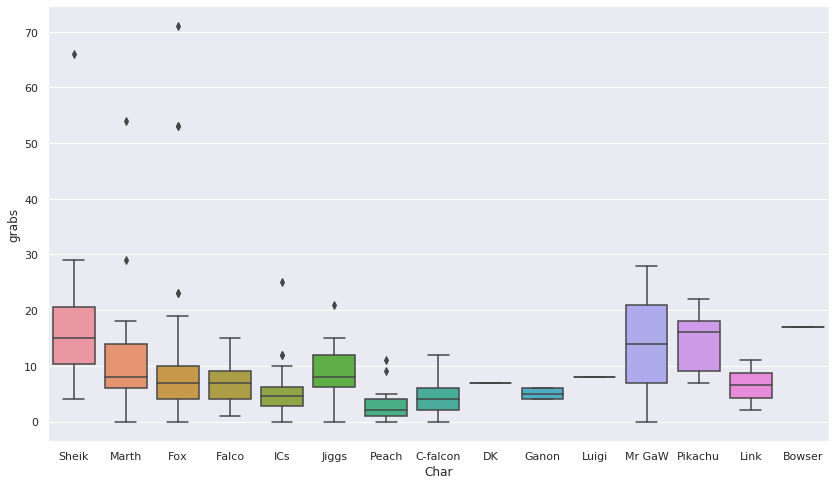

In [45]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Char', y='grabs', data=char_grab_df)

## Ledge Grabs vs Game Time

Below, we visualize the ledge grabs of the winner vs the amount of time the game took. Linear regression predicts a slight positive correlation, but the margin of error is decently wide, and there are quite a few outliers. Regardless, we decide to discard the idea that there is a relationship for a number of other factors. 

The strongest factor in this decision is that, naturally, as a game goes on, the ledge will be grabbed more times. Characters are obviously living longer, and so they are getting back to stage more often, and thus grabbing the ledge more often. So, a positive relationship is expected between ledge grabs and game time. It is just difficult to pin down which of these variables has more influence over the other.

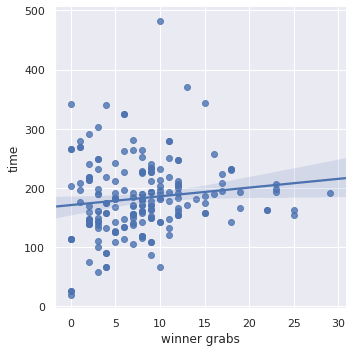

In [26]:
sns.lmplot(x='winner grabs', y='time', data=df)

## Ledge Grabs vs Win/Loss
Once again, to analyze this we must create a new dataframe and visualize it. We follow the same sort of method as the ledge grabs vs character section, in that we make a column that denotes a categorical variable (this time win vs loss) and a column which denotes a numerical variable (this time grabs per second). Now we can group the data to plot grabs per second for winners of a game, and grabs per second for losers of a game.

In [29]:
winloss_df = pd.DataFrame(columns = ['Win/Loss', 'grabs per second'])

winloss = []
grabs = []

for i, row in df.iterrows():
    winloss.append('Win')
    grabs.append(row['winner grabs'] / row['time'])
    winloss.append('Lose')
    grabs.append(row['loser grabs'] / row['time'])
    
winloss_df['Win/Loss'] = winloss
winloss_df['grabs per second'] = grabs
winloss_df

Win/Loss  grabs per second
0        Win          0.050847
1       Lose          0.067797
2        Win          0.030000
3       Lose          0.010000
4        Win          0.020833
..       ...               ...
387     Lose          0.044335
388      Win          0.085714
389     Lose          0.040000
390      Win          0.134969
391     Lose          0.036810

[392 rows x 2 columns]

Below, the box and whisker plots of grabs per second for winners and losers are displayed. Overwhelmingly, these plots are the same. The interquartile range is very similar, and the median of the winner’s grabs per second is only very slightly higher. This is somewhat to be expected though, as the majority of Melee players do not employ planking in their gameplay. When playing the game with the offensive strategy aim of eliminating the opponent's stocks, the defensive strategy of excessively grabbing ledge will not help them achieve that goal.

However, it is worth noting that the number of games where the planking strategy is put into full effect are few and far between, often only when someone feels truly pushed into the corner. For Pound 2019, it seems that nobody was truly forced to employ this strategy. Though if you examine outliers from other tournaments, such as game 3 of Hungrybox vs Mang0 at EVO 2015, you can see that stalling the game by grabbing the ledge often (once every 3.5 seconds for this set!) is an effective strategy to force a win, and that it is clearly different from normal play.

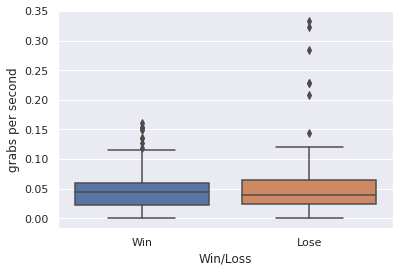

In [30]:
sns.boxplot(x='Win/Loss', y='grabs per second', data=winloss_df)

## Ledge Grabs vs Stage Choice

What stage is chosen in a match can have a significant impact on which player is more likely to win. This is due to certain characters performing better on certain stages as well as player preference. Here we will see how much if at all the ledge grabs by both players combined vary across stages. The sizes and layouts of each stage are different, which may lead to varying rates of ledge grabbing.

* Create a dataframe that will hold the stage name and average grabs per second by both players for that stage
* Iterate over every game, storing the relevant information in the dataframe

In [31]:
stage_df = pd.DataFrame(columns=['stage', 'grabs'])

for i, row in df.iterrows():
    stage_df = stage_df.append({'stage': row['stage'], 'grabs': (row['player1 grabs'] + row['player2 grabs']) / row['time']}, ignore_index=True)
    
stage_df

stage     grabs
0         BF  0.118644
1         FD  0.040000
2        FoD  0.069444
3    Yoshi's  0.487654
4         DL  0.048327
..       ...       ...
191      FoD  0.077626
192       DL  0.060484
193       BF  0.103448
194  Yoshi's  0.125714
195       FD  0.171779

[196 rows x 2 columns]

Looking at the plot below, one can see that between these six unique stages, there isn’t all that much of a significant difference. The medians are roughly similar, the interquartile ranges vary a bit (but not as much as compared to the ledge grabs vs character plots) and the upper and lower extremes also vary a bit. It is worth noting the three stages that have lower extremes and IQRs are Fountain of Dreams: a popular choice for characters with a strong ability to stall, Dreamland: again a popular choice for character with a strong ability to stall, and Pokemon Stadium: the one counterpick stage (<a href=https://www.ssbwiki.com/Stage_legality#Categories>What is a counterpick stage?</a>). 

This may seem counterintuitive, since stages that stall characters like to go to should have a higher prevalence of stalling, right? Not exactly, in fact, even the opposite. If a character counterpicks to a stage they prefer, they are less likely to stall because they have other viable methods of winning on that stage. At the same time, if a stall character gets counterpicked to a stage they don’t like, they are more likely to enact the stage-independent strategy of ledge stalling in the effort to secure a win. This means that counterpick stages will generally have less stalling.

Despite this, we will only conclude from this data that stage has very little influence over whether or not a character will stall on the ledge. At least, it does not have nearly as high an impact as the character themselves.

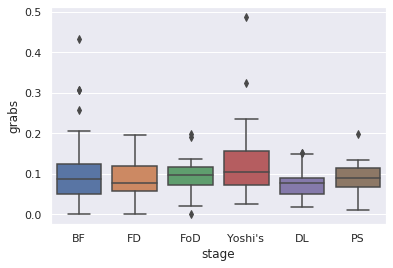

In [32]:
sns.boxplot(x='stage', y='grabs', data=stage_df)

# Conclusion and Policy Decision
This analysis leads us to the conclusion that a rule should be put in place. Largely, we were only able to examine how Melee games go on average, but that just emphasizes how drastically different the outlier games where planking was used really are. It shows that planking is a truly unique tactic that deviates from the normal core values of gameplay, and so it deserves careful scrutiny. In the future, we would love to continue this experiment and expand it out across more data from more tournaments, so that we may achieve better insight into the specifics of a proposed rule. We can reach one definitive conclusion from this data though, and that is that if a rule is implemented, the ledge grab limits must vary per character. Different characters have wildly different ledge grabs frequencies in normal matches, and so each character has a different number of ledge grabs that may be considered "extreme". We hope that the competitive community will take this into consideration if an official rule is eventually put in place.

Despite Melee's popularity, there has been very little work done into analyzing the game on a scientific level. However, with the Slippi Project, the amount of available data for analyzing Melee will only continue to grow, and so will the amount of knowledge about the game. As you can tell, this game has a lot more depth than it lets on at a glance. We hope we successfully showed the merit of examining it, and helped teach about the game and its intricacies! Just as well, we hope we showed how cool and interesting data science can be, and how it can be applied to almost anything (especially if you’re passionate about it)! Thank you so much for reading.

-- Clark Farley and William Fisher